###### The latest version of this IPython notebook is available at [http://github.com/jckantor/CBE20255](http://github.com/jckantor/CBE20255)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

J.C. Kantor (Kantor.1@nd.edu)

# Steam Reforming of Methane

This [Jupyter notebook](http://jupyter.org/notebook.html) demonstrates the formulation and solution of a reactor equilibrium problem at a known temperature and pressure. The notebook uses functional programming techniques including Python's lambda and map functions.

## Problem Statement

The steam reforming of methane 

$$ CH_4(g) + H_2O(g) \longrightarrow CO(g) + 3\,H_2(g) $$

is an endothermic reaction for the production of hydrogen. The reaction is normally conducted at relatively high temperatures and pressures over a heterogeneous catalyst. Assuming the reaction is carried out with 20% excess water at 20 atm, solve for the equilibrium extent of reaction as a function of temperature. Then plot methane predicted conversion as a function of operating temperature.

## Solution

For an ideal mixture of gases at equilibrium,

$$K_{rxn}(T) = \prod_{c=1}^C \left(y_cP\right)^{\nu_c}$$

or, after taking logarithms,

$$\ln K_{rxn}(T) = \sum_{c=1}^C \nu_c \ln\left(y_cP\right)$$

where $K_{rxn}(T)$ is the equilibrium constant, $y_c$ is the mole fraction of component $c$, $\nu_c$ is the stoichiometric coefficient of component $c$, $P$ and $T$ are pressure and temperature, respectively.

The strategy for solving this problem is to use the Van't Hoff equation to write a Python function to compute the left-hand side of the equation as a function of temperature, and the component material balances to solve for the quotient on the right-hand side as a function of the extent of reaction. Then, given a temperature and pressure, the equation is solved for the equilibrium extent of reaction using a root-finding algorithm.


### Notebook Initialization

Initialize the Python workspace.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

### Problem Data

The problem data is aggregated into the following cells for convenience. Adjust these parameters to do parametric studies of reactor performance.

In [2]:
# Reaction Conditions
P = 20
Tmin = 800
Tmax = 1200

# Reactor Feed Specifications
nIn = dict()
nIn['CH4'] = 1
nIn['H2O'] = 1.2*nIn['CH4']
nIn['CO'] = 0
nIn['H2'] = 0

# List of Components
C = nIn.keys()

### Component Data

We begin by gathering the molar enthalpy and Gibb's free energy of the species participating in the reaction at standard conditions.

<table>
<thead>
  <tr>
    <th> Species </th> 
    <th> $\Delta\hat{G}_f^{\circ}$ <br> [kJ/gmol] </th>
    <th> $\Delta\hat{H}_f^{\circ}$ <br> [kJ/gmol] </th>
  </tr>
</thead>
<tbody>
  <tr>
    <td> Carbon Monoxide (g) </td>
    <td> -137.27 </td>
    <td> -110.53 </td>
  <tr>
  <tr>
    <td> Hydrogen (g) </td>
    <td> 0 </td>
    <td> 0 </td>
  <tr>
  <tr>
    <td> Methane (g) </td>
    <td> -50.49 </td>
    <td> -74.52 </td>
  <tr>
  <tr>
    <td> Water (g) </td>
    <td> -228.59 </td>
    <td> -241.83 </td>
  <tr>
</tbody>
</table>

In [3]:
# Enthalpy and Free Energy of Formation
Gf = dict()
Hf = dict()

Gf['CO'] = -137270
Hf['CO'] = -110530

Gf['H2'] = 0
Hf['H2'] = 0

Gf['CH4'] = -50490
Hf['CH4'] = -74520

Gf['H2O'] = -228590
Hf['H2O'] = -241830

### Enthalpy and Gibb's Free Energy of Reaction

The enthalpy and Gibb's free energy per mole extent of reaction are given by

$$\begin{align*}
\Delta\hat{H}_{rxn}^{\circ} & = \sum_{c=1}^C \nu_c \Delta\hat{H}_{f,c}^{\circ} \\
\Delta\hat{G}_{rxn}^{\circ} & = \sum_{c=1}^C \nu_c \Delta\hat{G}_{f,c}^{\circ} 
\end{align*}$$

where $\nu_c$ is the stoichiometric coefficient for species $c$.

In [4]:
# Reaction Stoichiometry
nu = dict()
nu['CO']  = +1
nu['H2']  = +3
nu['CH4'] = -1
nu['H2O'] = -1

Hr = sum([nu[c]*Hf[c] for c in C])
print("Hr = {:7.3f} kJ/gmol".format(Hr/1000))

Gr = sum([nu[c]*Gf[c] for c in C])
print("Gr = {:7.3f} kJ/gmol".format(Gr/1000))

Hr = 205.820 kJ/gmol
Gr = 141.810 kJ/gmol


### Equilibrium Constant using van't Hoff Equation

The equilibrium constant as a function of temperature can be estimated using the Van't Hoff equation. 

$$ \ln K_r(T) = -\frac{1}{R}\left[\frac{\Delta\hat{G}_{rxn}^{\circ} - 
  \Delta\hat{H}_{rxn}^{\circ}}{298} + \frac{\Delta\hat{H}_{rxn}^{\circ}}{T}\right] $$

This is implemented in Python as a lambda function of $T$

In [5]:
R = 8.314 # J/K/gmol
def lnKr(T):
    return -((Gr-Hr)/298 + Hr/T)/R

which can be plotted over the temperature range of interest.

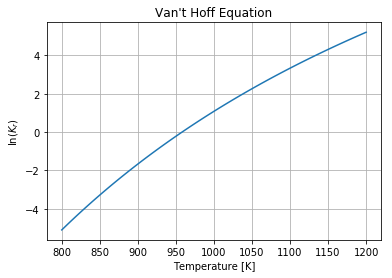

In [6]:
T = np.linspace(Tmin,Tmax,100)
plt.plot(T,[lnKr(T) for T in T])
plt.xlabel('Temperature [K]')
plt.ylabel('$\ln(K_{r})$')
plt.title('Van\'t Hoff Equation')
plt.grid()

### Material Balances

Given the problem data, the material balances can be solved to determine the molar flows at the outlet of the reactor as functions of the molar extent of reaction $\dot{\xi}$

$$\begin{align*}
\dot{n}_{out,CO} & = \dot{n}_{in,CO} + \nu_{CO}\dot{\xi} \\
\dot{n}_{out,H_2} & = \dot{n}_{in,H_2} + \nu_{H_2}\dot{\xi} \\
\dot{n}_{out,CH_4} & = \dot{n}_{in,CH_4} + \nu_{CH_4}\dot{\xi} \\
\dot{n}_{out,H_2O} & = \dot{n}_{in,H_2O} + \nu_{H_2O}\dot{\xi} 
\end{align*}$$


The material balances are implemented as lambda functions of molar extent $x$. The lambda functions are assigned to a dictionary nOut. (The extra default argument c=c is added so that the c referenced in the lambda function is the same as the key of the dictionary. Without the c=c argument, the c inside the lambda function refers to counter variable rather than the desired value of the key.)

In [7]:
nOut = dict()
for c in C:
    nOut[c] = lambda x,c=c: nIn[c] + nu[c]*x

The outlet molar flows can be plotted as functions of molar extent of reaction. The first step is to compute the maximum possible extent, then to plot each of the molar flows as a function of extent.

Maximum molar extent of reaction = 1.00


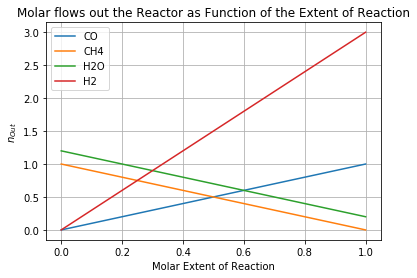

In [8]:
xMax = np.Inf
for c in C:
    if nu[c] < 0:
        xMax = min(xMax,-nIn[c]/nu[c])

print('Maximum molar extent of reaction = {:.2f}'.format(xMax))

x = np.linspace(0,xMax)

for c in C:
    plt.plot(x,[nOut[c](x) for x in x])
plt.legend(C)
plt.xlabel('Molar Extent of Reaction')
plt.ylabel('$n_{Out}$')
plt.title('Molar flows out the Reactor as Function of the Extent of Reaction')
plt.grid()

### Composition of the Reactor Outlet Gases

The composition of the reactor outlet gases is given by

$$ y_{n}(\dot{\xi}) = \frac{\dot{n}_{out,n}(\dot{\xi})}{\dot{n}_{Total}(\dot{\xi})} $$

where the total molar flow is sum of the component molar flows.

$$\begin{align*}
\dot{n}_{Total} & = \sum_{c=1}^C \dot{n}_{out,c} \\
& = \sum_{c=1}^C \dot{n}_{in,c} + \left(\sum_{c=1}^C \nu_c\right)\dot{\xi}
\end{align*}$$

The total molar flow is implement as a Python function.

In [9]:
def nTotal(x):
    nTotal = 0
    for c in C:
        nTotal += nOut[c](x)
    return nTotal

which is used to create a dictionary of lambda functions for the composition of the reactor effluent as functions of extent of reaction.

In [10]:
y = dict()
for c in C:
    y[c] = lambda x,c=c: nOut[c](x)/nTotal(x)

Plotting composition as a function of extent of reaction.

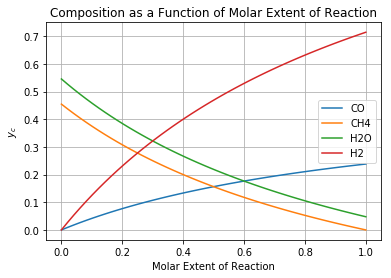

In [11]:
x = np.linspace(0,1)
for c in C:
    plt.plot(x,[y[c](x) for x in x])
plt.legend(C)
plt.xlabel('Molar Extent of Reaction')
plt.ylabel('$y_c$')
plt.title('Composition as a Function of Molar Extent of Reaction')
plt.grid()

### Reaction Quotient

For a gas phase reaction involving a mixture of ideal gases, we define a reaction quotient as

$$K_a(\dot{\xi}) = \prod_{c=1}^C \left(y_c(\dot{\xi})P\right)^{\nu_c}$$

where $y_c(\dot{\xi})P$ is the partial pressure of component $c$. Taking the logarithm

$$ \ln K_a(\dot{\xi}) = \sum_{c=1}^C \nu_c\ln(y_c(\dot{\xi})P)$$

This is implemented as a Python function.

In [12]:
def lnKa(x):
    lnKa = 0;
    for c in C:
        lnKa += nu[c]*np.log(P*y[c](x))
    return lnKa

/Users/jeff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


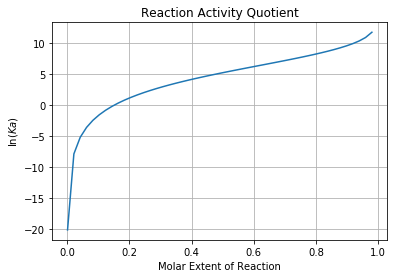

In [13]:
x = np.linspace(0.001,1)
plt.plot(x,[lnKa(x) for x in x])
plt.xlabel('Molar Extent of Reaction')
plt.ylabel('$\ln(Ka)$')
plt.title('Reaction Activity Quotient');
plt.grid()

### Solving for the Equilibrium Extent of Reaction

For a given temperature and pressure, the solution for the equilibrium extent of reaction is the value of $\dot{\xi}$ for which $K_r(T) = K_a(\dot{\xi})$ which can be written in terms of logarithms as

$$\ln K_r(T) = \ln K_a(\dot{\xi})$$

Plotting these functions side-by-side shows a simple graphical technique for finding solutions for $\dot{\xi}$.

/Users/jeff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


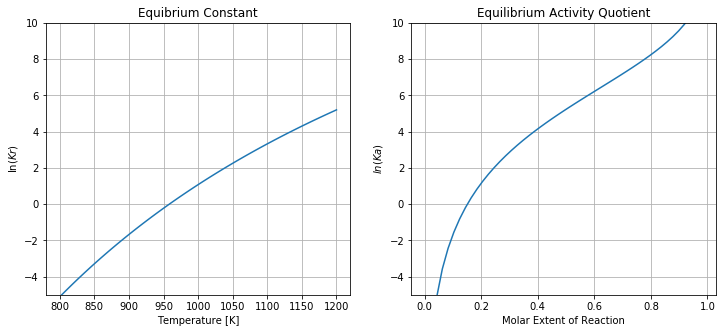

In [14]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(T,[lnKr(T) for T in T])
plt.ylim(-5,10)
plt.xlabel('Temperature [K]')
plt.ylabel('$\ln(Kr)$')
plt.title('Equibrium Constant')
plt.grid()

plt.subplot(1,2,2)
plt.plot(x,[lnKa(x) for x in x])
plt.ylim(-5,10)
plt.xlabel('Molar Extent of Reaction')
plt.ylabel('$ln(Ka)$')
plt.title('Equilibrium Activity Quotient')
plt.grid()

We'll let $\dot{\xi}_{eq}(T)$ denote equilibrium value of the extent as a function of temperature. Those values are defined as roots to the equation

$$ \ln K_a(\dot{\xi}_{eq}(T)) - \ln K_r(T) = 0$$

This implemented as a Python lambda function where a root=finding algorithm is used to solve the equilibrium condition as a function of temperature.


In [15]:
from scipy.optimize import brentq as fzero

xEquil = lambda T: fzero(lambda x: lnKa(x) - lnKr(T), 0, xMax)

Plotting

/Users/jeff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


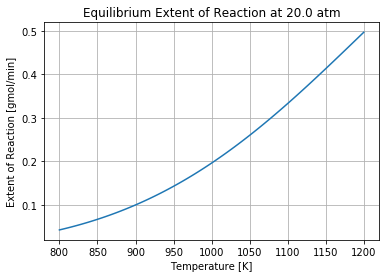

In [16]:
plt.plot(T,[xEquil(T) for T in T])
plt.xlabel('Temperature [K]')
plt.ylabel('Extent of Reaction [gmol/min]')
plt.title('Equilibrium Extent of Reaction at {:.1f} atm'.format(P))
plt.grid()

### Equilibrium Composition

Now that we have a function to compute the equilibrium extent of reaction as a function of temperature, we have everything needed to calculate a variety of performance metrics for the reactor. For example, we can use the functions we've already created for the outlet gas composition to compute and plot the reactor outlet gas composition as a function of temperature.

/Users/jeff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


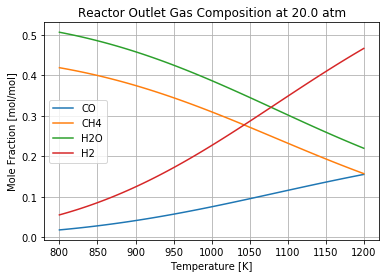

In [17]:
yEquil = dict()
for c in C:
    yEquil[c] = lambda T,c=c: y[c](xEquil(T))

for c in C:
    plt.plot(T,[yEquil[c](T) for T in T])

plt.legend(C)
plt.xlabel('Temperature [K]')
plt.ylabel('Mole Fraction [mol/mol]')
plt.title('Reactor Outlet Gas Composition at {:.1f} atm'.format(P))
plt.grid()


### Methane Conversion

$$f_{conv} = \frac{\dot{n}_{in,CH_4} - \dot{n}_{out,CH_4}}{\dot{n}_{in,CH_4}}$$

/Users/jeff/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


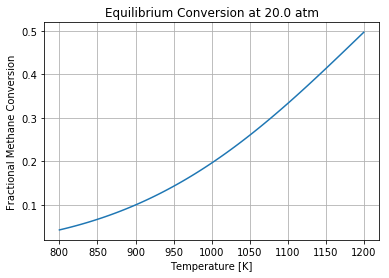

In [18]:
fconv = lambda T: (nIn['CH4'] - nOut['CH4'](xEquil(T)))/nIn['CH4']

plt.plot(T,[fconv(T) for T in T])
plt.xlabel('Temperature [K]')
plt.ylabel('Fractional Methane Conversion')
plt.title('Equilibrium Conversion at {:.1f} atm'.format(P))
plt.grid()

## Exercises

1. Repeat the calculations for different operating pressures. How does equilibrium extent of reaction depend on operating pressure?  Why is this the case?
2. Repeat the calculations for different feed ratios for water and methane. How does extent of reaction depend on the feed ratio of water?
3. Find component heat capacity data, then write a function to compute the heat requirement for the reactor. If the reactor is operated adiabatically, what is the temperature difference between the inlet and outlet streams?